In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch 
import torch.nn as nn
import torchvision
#import datasets in torchvision
import torchvision.datasets as datasets

#import model zoo in torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load alexnet 

alexnet = models.alexnet(pretrained=True)

In [3]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Let's look at the kernels in detail

## Layer:1 

In [4]:
conv1 = alexnet.features[0]

conv1

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

- Layer 1 takes input images with 3 channels.
- 64 kernels with size (11, 11)

Note: This is different in the paper. In the paper, they had used 96 kernels in the first layer, although, in the pytorch implementation, there are 64 kernels in the first layer. 

In [5]:
conv1_weights = conv1.weight.data

print("Shape of conv1_weights = ", conv1_weights.shape)

Shape of conv1_weights =  torch.Size([64, 3, 11, 11])


The syantax is (out_channels, in_channels, kernel_height, kernel_width)

We are using 64 channels of size 11x11, having number of channels=3

Let's have a look at one of the 64 kernels 

In [6]:
sample_kernel = conv1.weight.data[0]

sample_kernel = sample_kernel.permute(1, 2, 0).cpu().numpy()

sample_kernel.shape

(11, 11, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24415785..0.57201004].


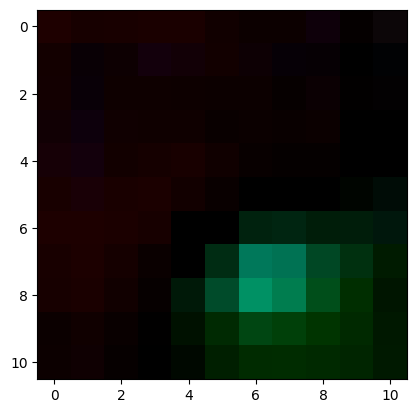

In [7]:
plt.imshow(sample_kernel)

The issue with the above graph is that the kernel has some negative values which are not handled well by plt.imshow. We will plot the histogram of this particular kernel to prove it -> 

(array([ 11.,  69., 125., 100.,  36.,   9.,   6.,   3.,   2.,   2.]),
 array([-0.24415785, -0.16254106, -0.08092427,  0.00069252,  0.08230931,
         0.16392609,  0.24554288,  0.32715967,  0.40877646,  0.49039325,
         0.57201004]),
 <BarContainer object of 10 artists>)

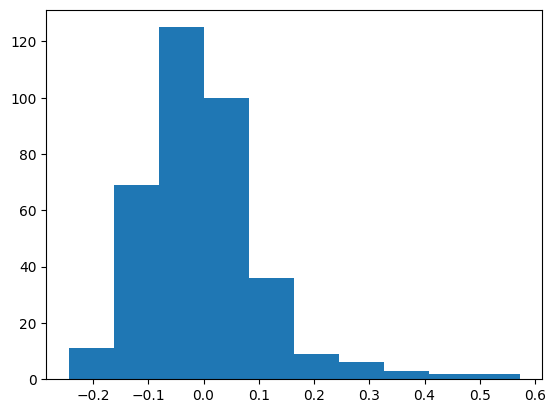

In [8]:
plt.hist(np.ravel(sample_kernel))

Let's normalize this kernel and visualize it again 

(array([ 11.,  69., 125., 100.,  36.,   9.,   6.,   3.,   2.,   2.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

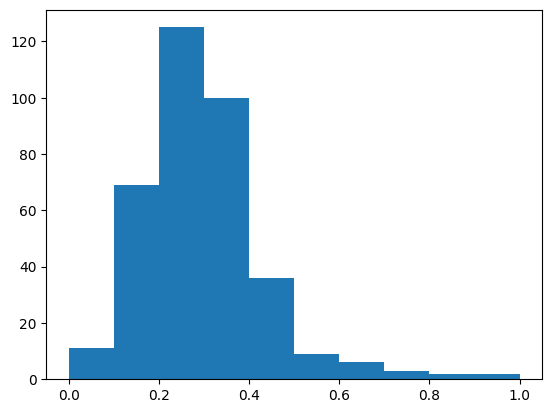

In [9]:
min_w = sample_kernel.min()
max_w = sample_kernel.max()
sample_kernel = (sample_kernel - min_w) / (max_w - min_w)

# plot the histogram again 

plt.hist(np.ravel(sample_kernel))

In the above graph, it can be seen that the values of the kernel are now in the range 0-1. We would be able to visualize it better. 

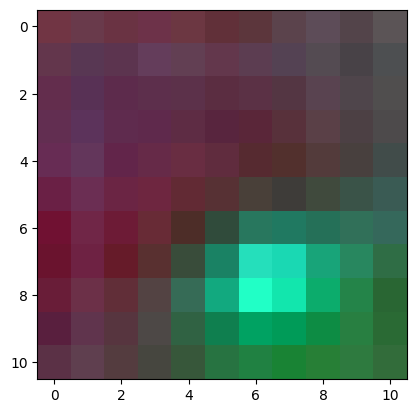

In [10]:
plt.imshow(sample_kernel)

This is a much better. Looks like this kernel is detecting green color in the bottom right, while right shape in the upper left. Note that these kernels are learnt during the training phase. Let's plot all of the 64 kernels in the first layer

### Plotting all of the 64 kernels in the first layer 

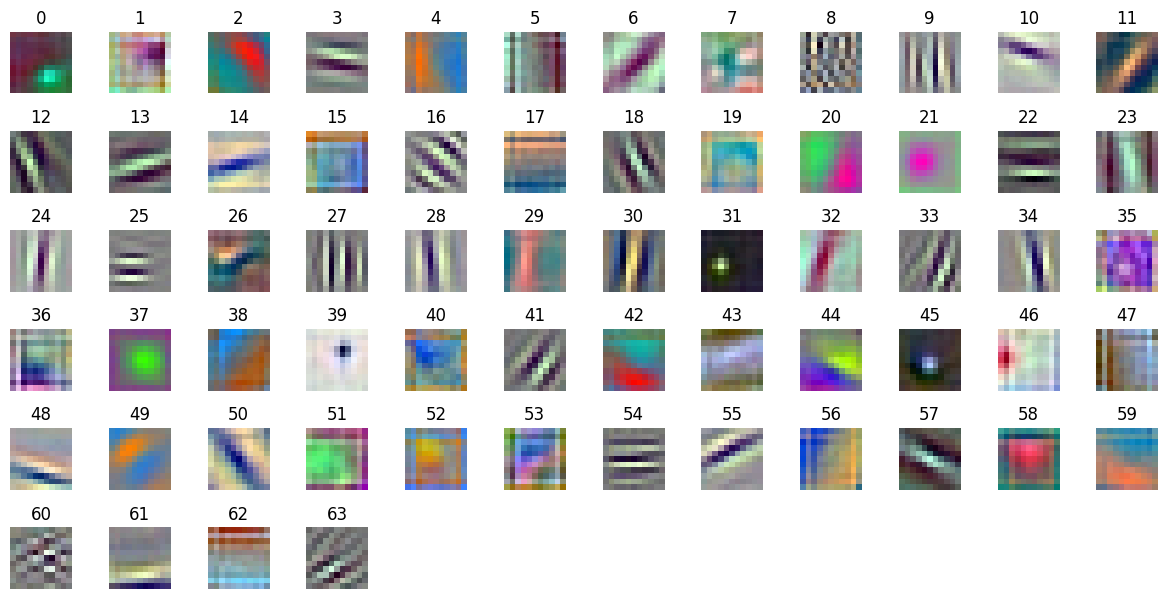

In [11]:
weight = conv1.weight.data

nplots = weight.shape[0]*weight.shape[1]
num_cols = 12

num_rows = 1 + nplots//num_cols
#convert tensor to numpy image
npimg = np.array(weight.numpy(), np.float32)

count = 0
fig = plt.figure(figsize=(num_cols, num_rows))

for i in range(weight.shape[0]):
    ax1 = fig.add_subplot(num_rows,num_cols,i+1)
    
    #for each kernel, we convert the tensor to numpy 
    npimg = np.array(weight[i].numpy(), np.float32)
    min_w = npimg.min()
    max_w = npimg.max()

    npimg = (npimg - min_w) / (max_w - min_w + 1e-5)
    
    
    #standardize the numpy image
    npimg = npimg.transpose((1, 2, 0))
    ax1.imshow(npimg)
    ax1.axis('off')
    ax1.set_title(str(i))
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    
plt.savefig('first_layer_kernels.png', dpi=100)    
plt.tight_layout()
plt.show()

## Clustering the above kernels in groups 

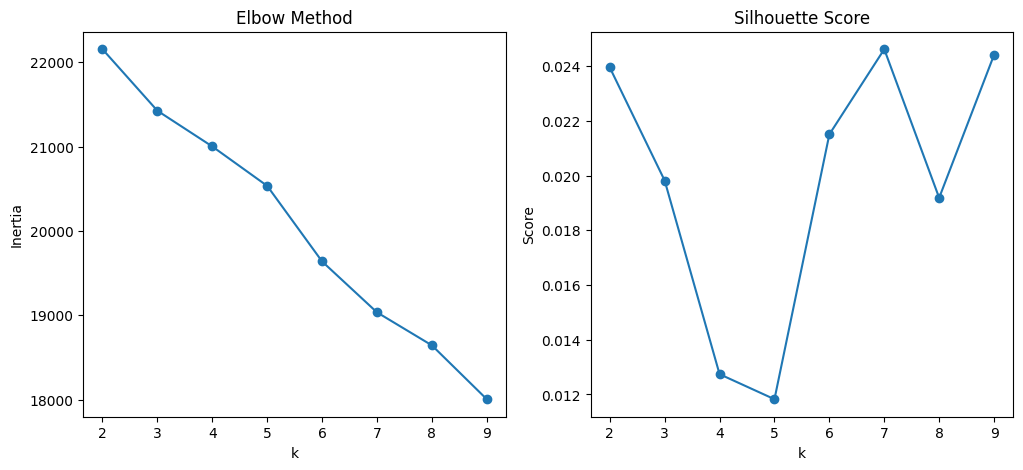

In [12]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Load pretrained AlexNet
weight = alexnet.features[0].weight.data.clone()  # (64, 3, 11, 11)

kernels = []

for i in range(weight.shape[0]):
    kernel = weight[i].clone().cpu().numpy()
    kernel_flat = kernel.flatten()
    kernel_flat = (kernel_flat - kernel_flat.mean()) / (kernel_flat.std() + 1e-5)
    kernels.append(kernel_flat)
    
kernels = np.stack(kernels) 

# Elbow method to find best k
inertia = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(kernels)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(kernels, kmeans.labels_))

# Plot Elbow
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, 'o-')
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")

# Plot Silhouette
plt.subplot(1, 2, 2)
plt.plot(K_range, sil_scores, 'o-')
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Score")
plt.show()


The elbow method is not "elbowing". Looks like a straight arm. I will choose k=6. 

### Clustering the kernels into 6 kernels 

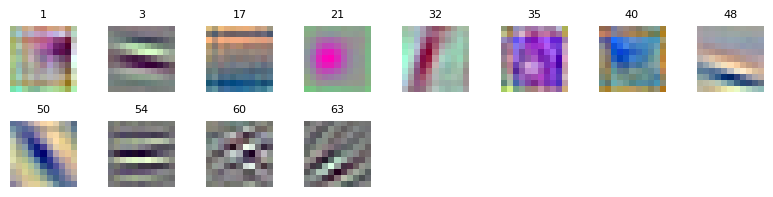

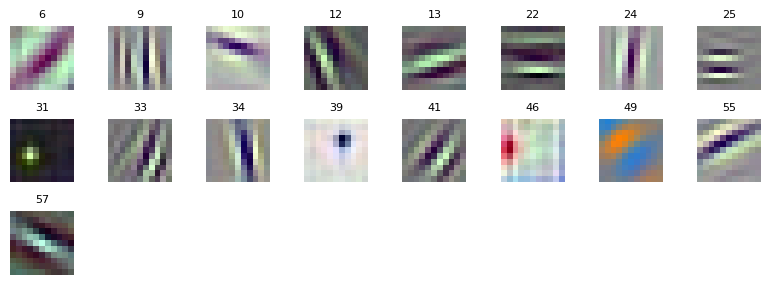

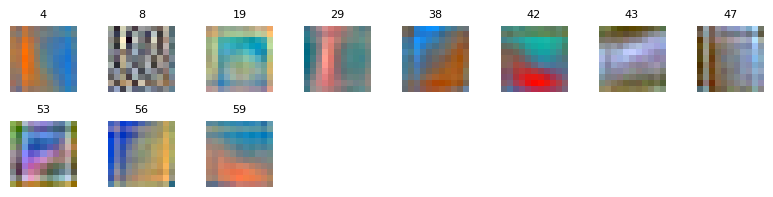

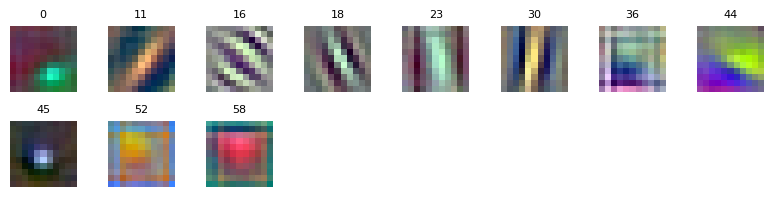

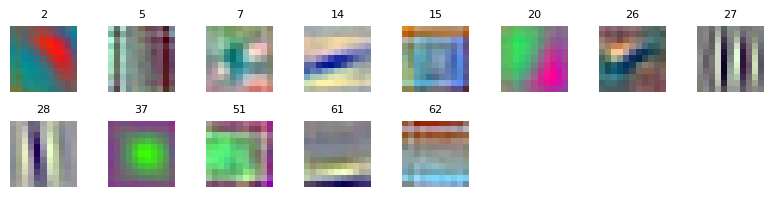

In [13]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(kernels)

def normalize_kernel(kernel):
    # Normalize each kernel individually to [0, 1]
    min_val = kernel.min()
    max_val = kernel.max()
    return (kernel - min_val) / (max_val - min_val)

for cluster_id in range(k):
    indices = np.where(labels == cluster_id)[0]
    num_kernels = len(indices)
    
    cols = 8
    rows = (num_kernels + cols - 1) // cols

    plt.figure(figsize=(cols, rows))
    #plt.suptitle(f"Cluster {cluster_id}", fontsize=16)

    for i, idx in enumerate(indices):
        kernel = weight[idx].cpu()
        kernel = normalize_kernel(kernel)

        # Move channel dimension to last for plotting: (3, 11, 11) → (11, 11, 3)
        kernel_img = np.transpose(kernel.numpy(), (1, 2, 0))

        plt.subplot(rows, cols, i + 1)
        plt.imshow(kernel_img)
        plt.axis("off")
        plt.title(str(idx), fontsize=8)

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # Leave space for cluster title
    plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans


In [15]:
weight = alexnet.features[0].weight.data.clone()

weight = weight.permute(0,2,3,1)

flattened_kernels = weight.reshape(64, -1)


In [16]:
weight.shape

torch.Size([64, 11, 11, 3])

In [17]:
scaler = StandardScaler()
normalized_kernels = scaler.fit_transform(flattened_kernels)
normalized_kernels = normalize(flattened_kernels)

In [18]:
k = 5  # or any reasonable value; use elbow method to decide
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(normalized_kernels)

In [19]:
def normalize_kernel(kernel):
    # Normalize each kernel individually to [0, 1]
    min_val = kernel.min()
    max_val = kernel.max()
    return (kernel - min_val) / (max_val - min_val)

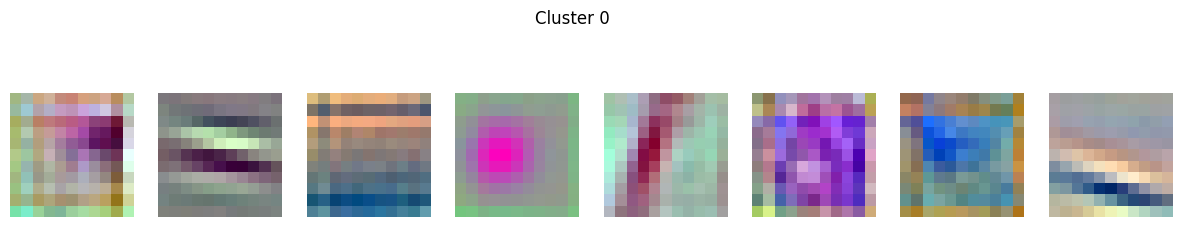

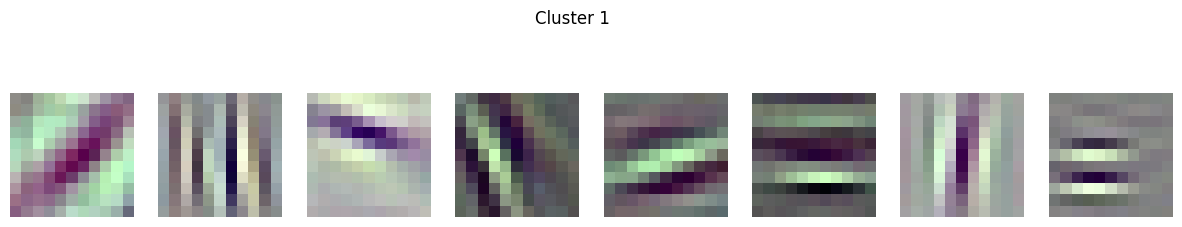

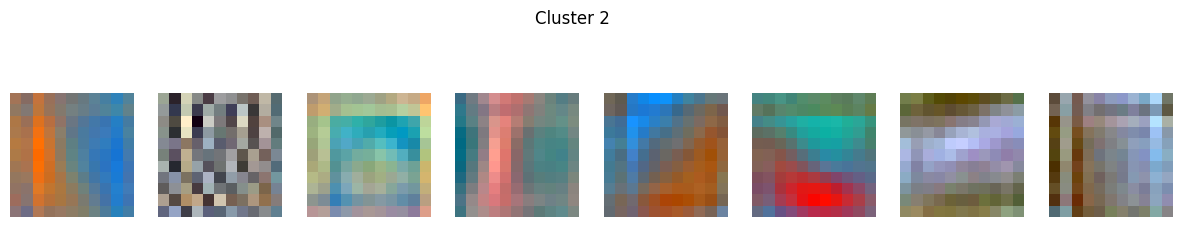

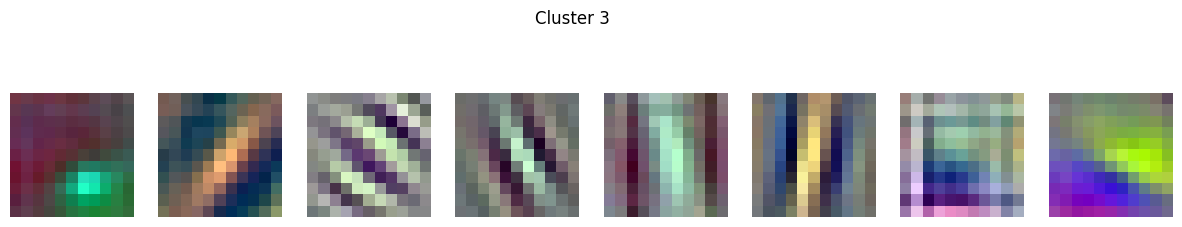

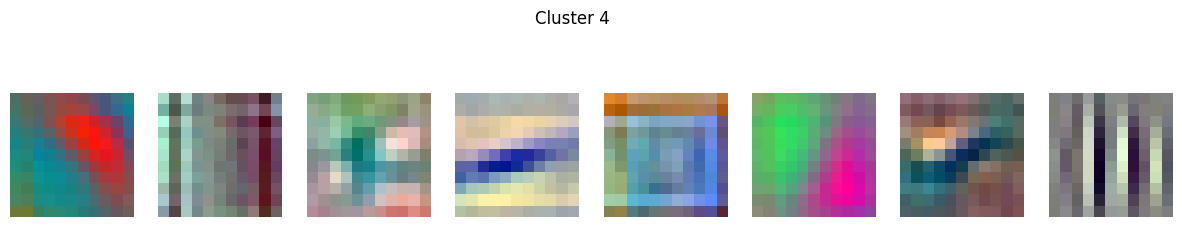

In [20]:
import matplotlib.pyplot as plt

for cluster_id in range(k):
    cluster_filters = weight[labels == cluster_id]
    fig, axs = plt.subplots(1, min(8, len(cluster_filters)), figsize=(15, 3))
    for i in range(len(axs)):
        axs[i].imshow(normalize_kernel(cluster_filters[i]))
        axs[i].axis('off')
    plt.suptitle(f'Cluster {cluster_id}')
    plt.savefig("clusters_" + str(cluster_id) + ".png")
    plt.show()


### It doesn't give the best of results. 

What could be done isntead - 

- Using Kmeans on filters directly, which uses euclidian distance might not be the best of choice.
- Pass an image, and then cluster on the type of output image.

## Try 2: clustering kernels by outputs from passing an image

In [21]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)


Files already downloaded and verified


In [22]:
import torchvision.models as models
import torch.nn as nn

alexnet = models.alexnet(pretrained=True).eval()
first_conv = alexnet.features[0]

In [23]:
import torch

all_responses = []

with torch.no_grad():
    for i, (images, _) in enumerate(loader):
        # Get activations from the first conv layer
        activations = first_conv(images)  # Shape: [B, 64, H, W]

        # Global average pooling over H and W to get 1 value per filter per image
        pooled = torch.mean(activations, dim=(2, 3))  # Shape: [B, 64]

        all_responses.append(pooled)

        if i == 20:  # Use 20 batches (640 images) for clustering
            break

# Stack into one large matrix: [N_images, 64]
response_matrix = torch.cat(all_responses, dim=0)  # Shape: [640, 64]


In [24]:
filter_features = response_matrix.T  # Shape: [64, 640]


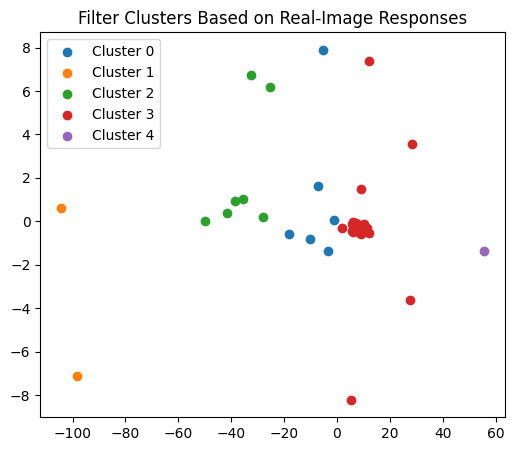

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

k = 5  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=0).fit(filter_features)
labels = kmeans.labels_

# Optional: Visualize with PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(filter_features)

plt.figure(figsize=(6, 5))
for i in range(k):
    plt.scatter(reduced[labels == i, 0], reduced[labels == i, 1], label=f'Cluster {i}')
plt.legend()
plt.title('Filter Clusters Based on Real-Image Responses')
plt.show()

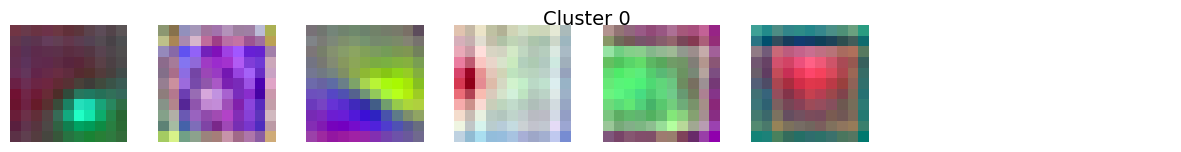

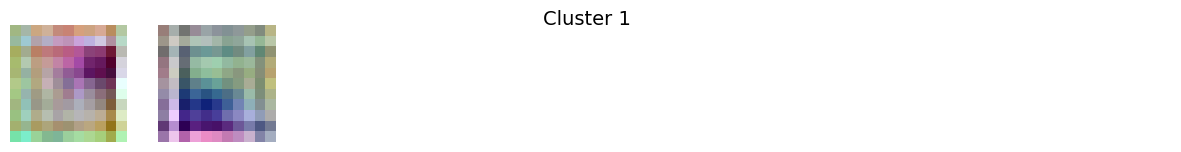

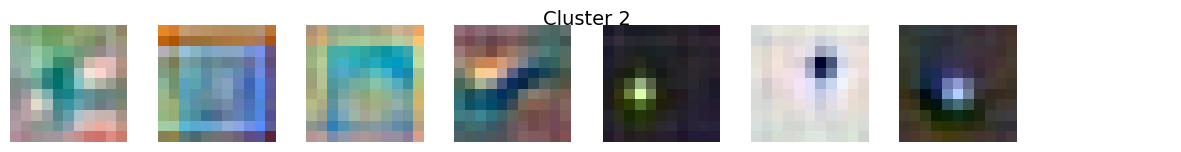

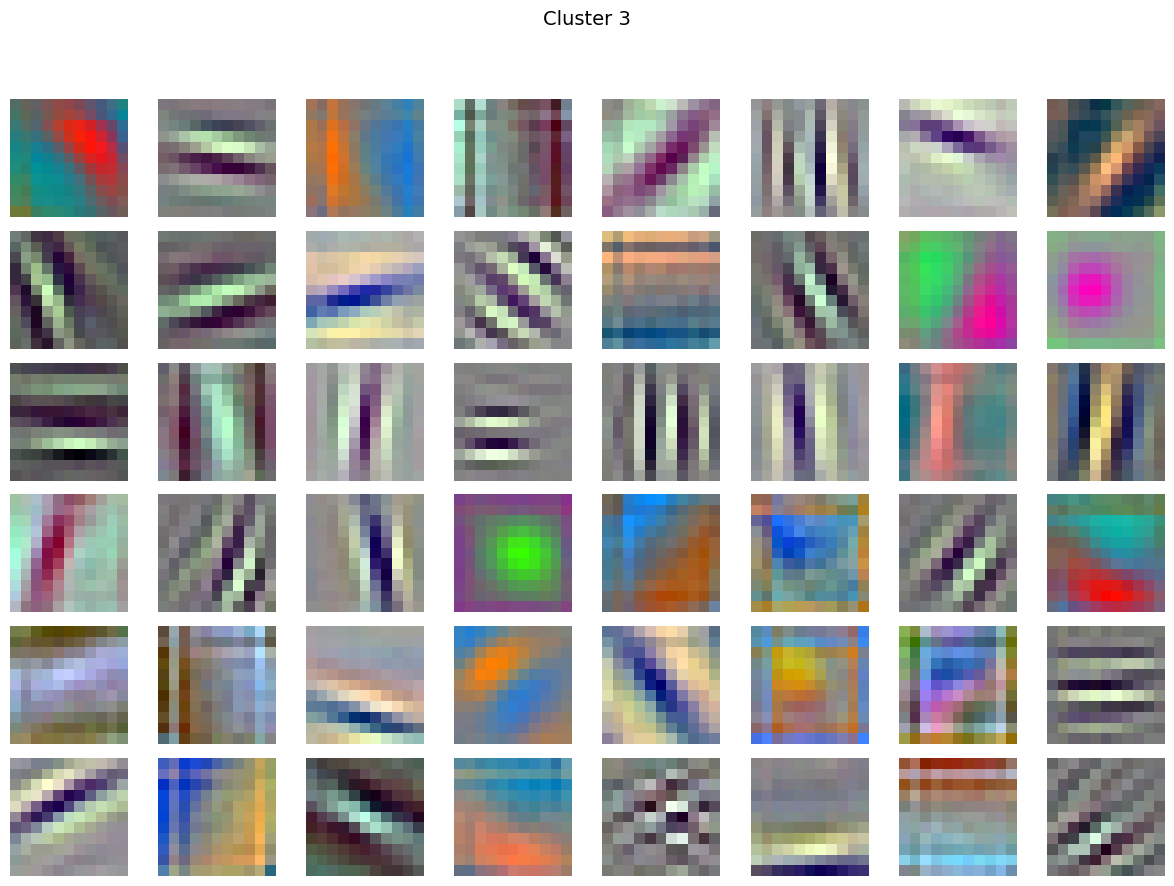

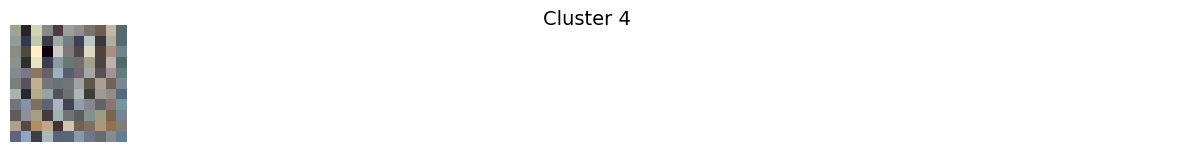

In [26]:
filters = first_conv.weight.data.clone()  # [64, 3, 11, 11]

for cluster_id in range(k):
    idxs = [i for i, label in enumerate(labels) if label == cluster_id]
    num_kernels = len(idxs)
    cols = 8
    rows = (num_kernels + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
    axs = axs.flatten()

    for j in range(rows * cols):
        ax = axs[j]
        ax.axis('off')

        if j < num_kernels:
            kernel = filters[idxs[j]].permute(1, 2, 0)  # [11, 11, 3]
            kernel = (kernel - kernel.min()) / (kernel.max() - kernel.min())  # Normalize
            ax.imshow(kernel)

    plt.suptitle(f"Cluster {cluster_id}", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

This is giving much better results. 
- Kernels in cluster-3 are detecting lines and shapes.
- In cluster-1, it seems to be detecting regions in individual channels. 
- In cluster-2, it sesms to be a mixture of color regions, and also some circular patterns. 

## Kernels for other layers 

- We visualized the 64 kernels in the first layer, now, let's see how the kernels of other layers looks like.
- The kernels present in the first layer had 3 channels, so we can visualize them by plotting them as RGB values. Also, the input to these kernels are RGB values.
- But the upcoming kernels are way thicker than 3 channels, and we cannot viualize them as RGB images. 



In [27]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load AlexNet pretrained model
alexnet = models.alexnet(pretrained=True)
alexnet.eval()

# Choose the layer you want to visualize (e.g., features[0] = conv1, features[3] = conv2)
layer_to_hook = alexnet.features[3]  # conv2





In [28]:
# it has input an image of 64 dimensions
# 192 total kernels of size (5,5)
layer_to_hook

Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

In [29]:
# List to store activations
activations = []

# Define hook function
def hook_fn(module, input, output):
    activations.append(output)

# Register hook
hook = layer_to_hook.register_forward_hook(hook_fn)

In [30]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

Files already downloaded and verified


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [32]:
images, labels = next(iter(loader))
images = images.to(device)

In [33]:
with torch.no_grad():
    _ = alexnet(images)


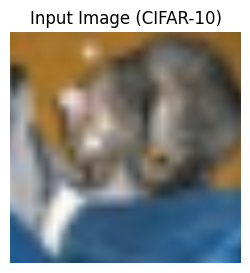

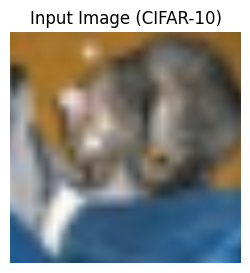

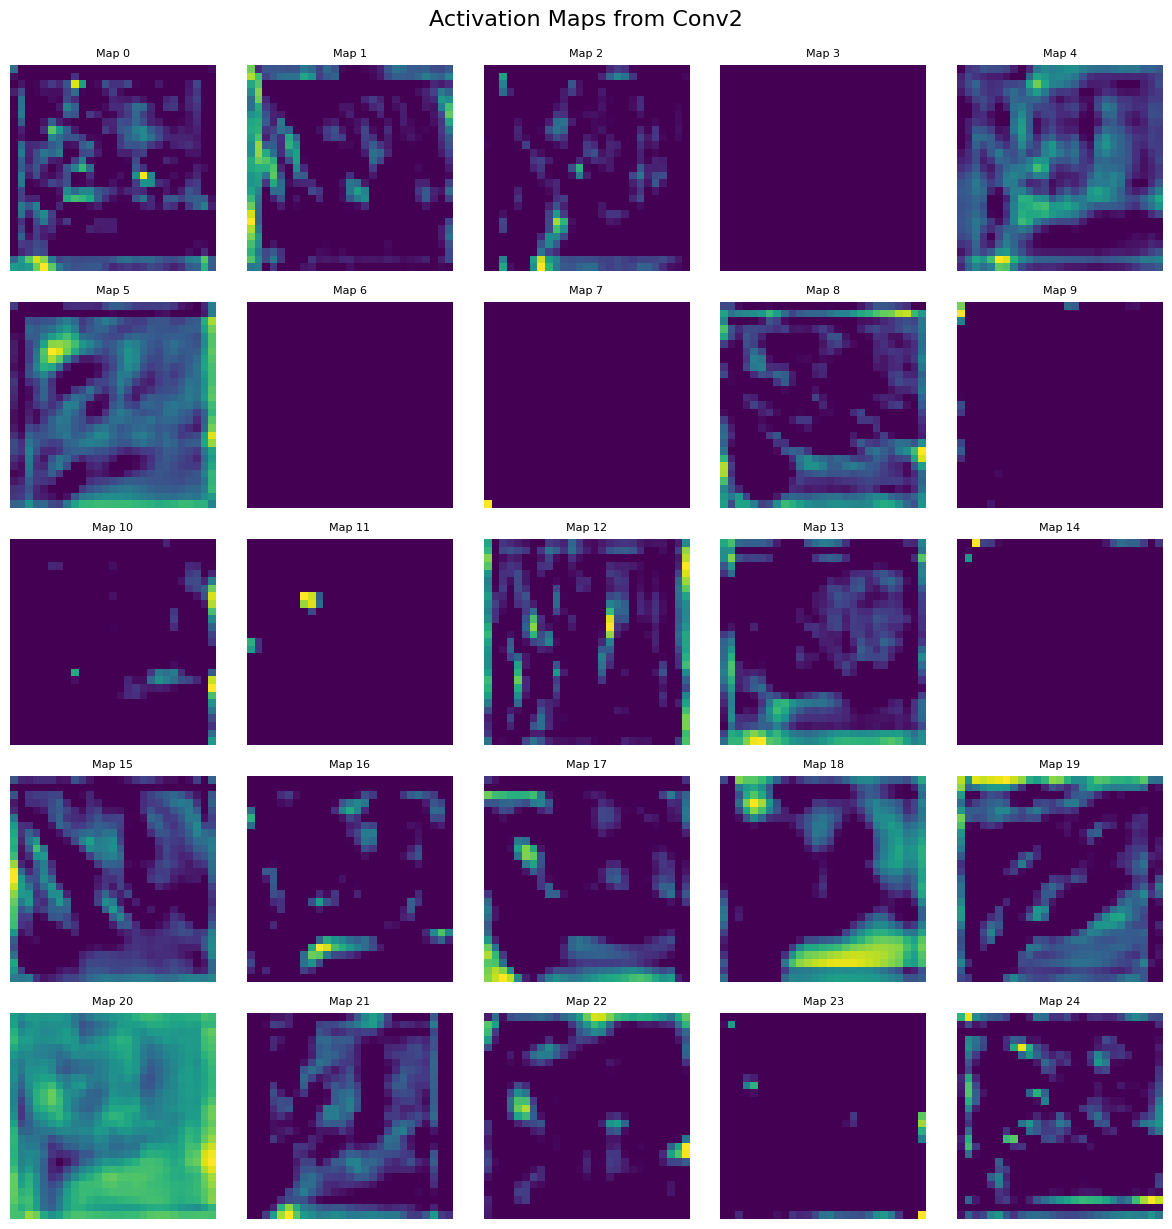

In [39]:
img_np = images[0].cpu().permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)
plt.figure(figsize=(3, 3))
plt.imshow(img_np)
plt.title("Input Image (CIFAR-10)")
plt.axis("off")
plt.show()

# Visualize first N activation maps in a grid
act = activations[0][0].cpu()  # shape: (num_channels, H, W)
num_maps = 25
rows = cols = 5

fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    ax.imshow(act[i], cmap='viridis')
    ax.set_title(f'Map {i}', fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.suptitle("Activation Maps from Conv2", fontsize=16, y=1.02)
plt.show()

# Clean up hook
hook.remove()